In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the model
class AE(nn.Module):
    def __init__(self, latent_dim=16, decay=0.8):
        super(AE, self).__init__()
        self.latent_dim = latent_dim
        self.decay = decay
        assert self.latent_dim >= 3
        assert 0.0 < self.decay < 1.0
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, self.latent_dim),
            # nn.Tanh(), # Constrain to -1, 1
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28),
        )

    def encode(self, x):
        l = self.encoder(x)
        h = l / (torch.norm(l, dim=1, keepdim=True) + 1e-6)
        return h, l

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        h, l = self.encode(x)
        return self.decode(h), (h, l)
    
def draw_samples(samples, latent_dim, decay=0.8):
    # Must be at least 3
    assert latent_dim >= 3
    d = torch.randn(samples, latent_dim)
    d = d / (torch.norm(d, dim=1, keepdim=True) + 1e-6)
    return d

# Plot samples for each plane
samples = 10000
latent_dim = 4  # Change this to the actual latent dimension

# Generate samples
d_samples = draw_samples(samples, latent_dim)
print(d_samples.shape)

torch.Size([10000, 4])


In [2]:
# Build model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./mnist_data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
myae = AE(latent_dim=latent_dim).to(device)

# Show variance of samples (diagonal)
mean_samples = torch.mean(d_samples, dim=0)
std_samples = torch.std(d_samples, dim=0, unbiased=True)
d_samples_m = d_samples - mean_samples
cov_samples = torch.matmul(d_samples_m.T, d_samples_m) / samples
print(mean_samples)
print(std_samples)
print(cov_samples)
mean_samples = mean_samples.to(device)
std_samples = std_samples.to(device)
cov_samples = cov_samples.to(device)

Using device cuda
tensor([ 0.0032, -0.0029, -0.0047, -0.0047])
tensor([0.4988, 0.5000, 0.4984, 0.5027])
tensor([[ 0.2488,  0.0011,  0.0029, -0.0022],
        [ 0.0011,  0.2500, -0.0014,  0.0015],
        [ 0.0029, -0.0014,  0.2484,  0.0009],
        [-0.0022,  0.0015,  0.0009,  0.2527]])


In [3]:
import schedulefree
opt_ae = schedulefree.AdamWScheduleFree(myae.parameters(), lr=1e-3, betas=(0.95, 0.9999), weight_decay=1e-6, warmup_steps=100)
loss_fn = nn.L1Loss()
epochs = 200
pbar = tqdm(total=epochs)
for epoch in range(epochs):
    myae.train()
    for x, _ in train_loader:
        # Get reconstruction and latent representation
        opt_ae.train()
        x = x.to(device)
        opt_ae.zero_grad()
        recon, z = myae(x)

        # Reconstruction loss
        recon_loss = loss_fn(recon, x)

        # Moment matching
        reg_loss = (torch.mean(z[0], dim=0) - mean_samples).pow(2).sum()
        z_m = z[0] - torch.mean(z[0], dim=0)
        cov_z = torch.matmul(z_m.T, z_m) / x.size(0)
        reg_loss = reg_loss + (cov_z - cov_samples).pow(2).sum()

        # Get gradients (automatic differentiation)
        loss = recon_loss + reg_loss
        loss.backward()
        opt_ae.step()
        pbar.set_postfix({'Loss': loss.item(), 'Recon': recon_loss.item(), 'Reg': reg_loss.item()})
    pbar.update(1)
pbar.close()
opt_ae.eval()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [50:13<00:00, 15.07s/it, Loss=0.152, Recon=0.138, Reg=0.0138]  


In [4]:
# Go through the entire training dataset and label the latent space
myae.eval()
all_latents = []
all_labels = []
for x, y in train_loader:
    x = x.to(device)
    with torch.no_grad():
        _, z = myae(x)
        z = z[0].cpu()
    all_latents.append(z)
    all_labels.append(y)
all_latents = torch.cat(all_latents)
all_labels = torch.cat(all_labels)

In [5]:
import umap
# Umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_latents.cpu().numpy())

c:\Users\kevin\Desktop\Test\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


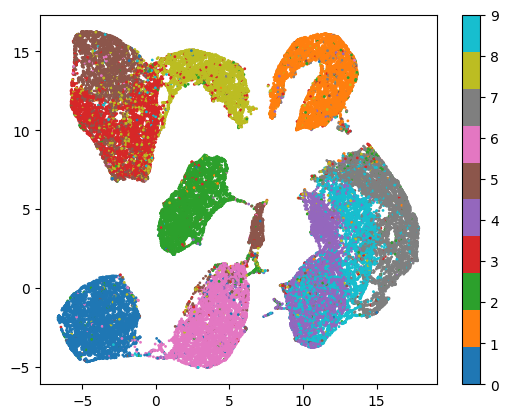

In [6]:
%matplotlib inline
plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels.cpu().numpy(), cmap='tab10', s=1)
plt.colorbar()
plt.show()
plt.close()

In [7]:
# UMAP on original data
reducer2 = umap.UMAP()
embedding2 = reducer2.fit_transform(train_dataset.data.view(-1, 28*28).numpy())

c:\Users\kevin\Desktop\Test\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


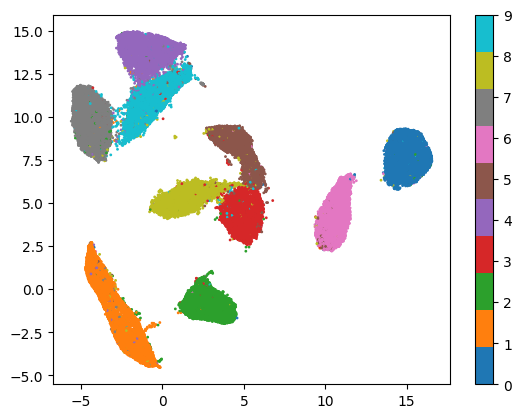

In [8]:
# Plot UMAP of original data
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=train_dataset.targets.numpy(), cmap='tab10', s=1)
plt.colorbar()
plt.show()
plt.close()

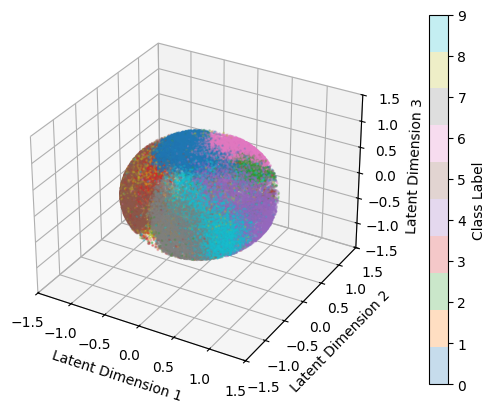

In [11]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget
%matplotlib inline

# Assuming all_latents and all_labels are already defined as in your code

# Convert tensors to numpy arrays for plotting
latents_np = all_latents.cpu().numpy()
labels_np = all_labels.cpu().numpy()

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color coding by class labels using tab10 colormap
scatter = ax.scatter(latents_np[:, 0], latents_np[:, 1], latents_np[:, 2], c=labels_np, cmap='tab10', alpha=0.25, s=1)

# Add a color bar
colorbar = fig.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_label('Class Label')

# Set labels for axes
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
# ax.view_init(elev=-30, azim=30)  # You can change these values to your preferred angles

# Show plot
plt.show()
plt.close()

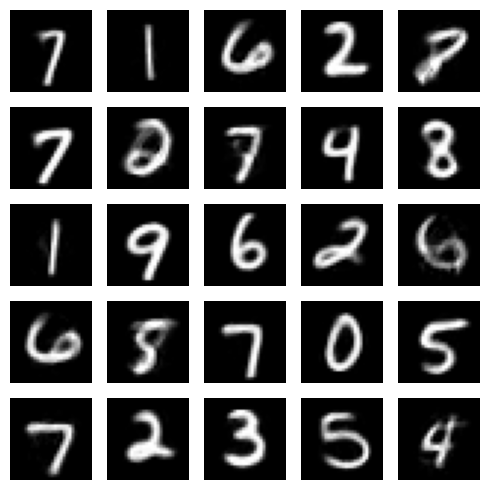

In [32]:
import matplotlib.pyplot as plt
import torch
# Draw samples from AE
myae.eval()
samples = draw_samples(25, latent_dim).to(device)
# samples = all_latents[np.random.choice(all_latents.shape[0], 25, replace=False)].to(device)
recon = myae.decode(samples)

# Determine grid size (close to square)
num_samples = samples.shape[0]
grid_size = int(num_samples**0.5)
if grid_size**2 < num_samples:
    grid_size += 1

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# Plot samples in grid
for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        if idx < num_samples:
            img = recon[idx].cpu().detach().numpy().squeeze()  # Assuming recon is in CHW format
            img = img.clip(-1, 1)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()